In [1]:
!pip install mutagen
!pip install nb_black > /dev/null

     |████████████████████████████████| 218 kB 512 kB/s            


In [2]:
%load_ext lab_black

In [3]:
import pandas as pd
import numpy as np


import mutagen
from mutagen.wave import WAVE
from mutagen.ogg import OggFileType

import json

import matplotlib.pylab as plt
import seaborn as sns
import plotly.express as px

# For exploring audio files
import librosa
import librosa.display
import IPython.display as ipd


# torch
import torch
import torchaudio

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from itertools import cycle

color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])


import IPython
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from pydub import AudioSegment

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


%matplotlib inline
import matplotlib.patches as mpl_patches
import matplotlib.pylab as pylab

params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (15, 8),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
    "text.color": "green",
}
pylab.rcParams.update(params)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
!mkdir ./metadata

   TAXON_ORDER CATEGORY SPECIES_CODE       PRIMARY_COM_NAME  \
0            1  species      ostric2         Common Ostrich   
1            6  species      ostric3         Somali Ostrich   
2            7    slash       y00934  Common/Somali Ostrich   
3            8  species      grerhe1           Greater Rhea   
4           14  species      lesrhe2            Lesser Rhea   

                         SCI_NAME            ORDER1  \
0                Struthio camelus  Struthioniformes   
1          Struthio molybdophanes  Struthioniformes   
2  Struthio camelus/molybdophanes  Struthioniformes   
3                  Rhea americana        Rheiformes   
4                    Rhea pennata        Rheiformes   

                      FAMILY SPECIES_GROUP REPORT_AS  
0  Struthionidae (Ostriches)     Ostriches       NaN  
1  Struthionidae (Ostriches)           NaN       NaN  
2  Struthionidae (Ostriches)           NaN       NaN  
3            Rheidae (Rheas)         Rheas       NaN  
4            Rh

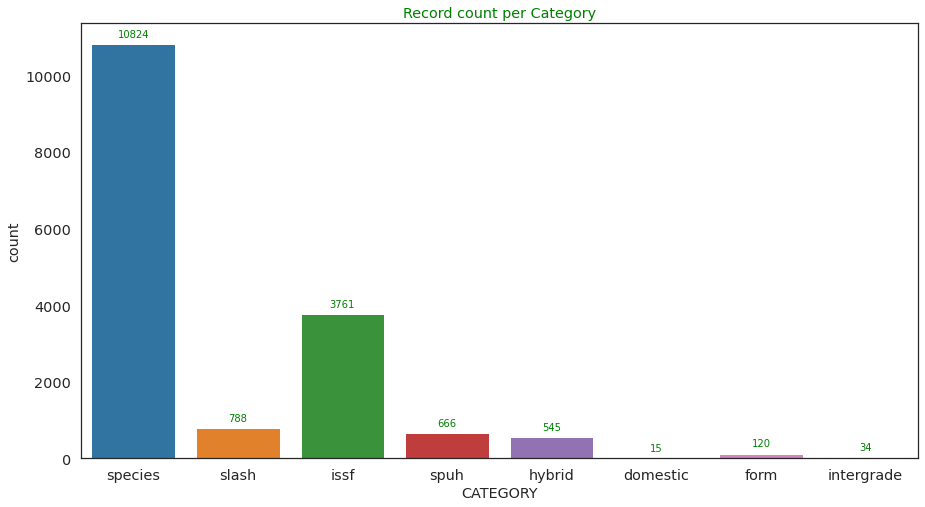

['akiapo', 'aniani', 'apapan', 'barpet', 'crehon', 'elepai', 'ercfra', 'hawama', 'hawcre', 'hawgoo', 'hawhaw', 'hawpet1', 'houfin', 'iiwi', 'jabwar', 'maupar', 'omao', 'puaioh', 'skylar', 'warwhe1', 'yefcan']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14852 entries, 0 to 14851
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     14852 non-null  object 
 1   secondary_labels  14852 non-null  object 
 2   type              14852 non-null  object 
 3   latitude          14852 non-null  float64
 4   longitude         14852 non-null  float64
 5   scientific_name   14852 non-null  object 
 6   common_name       14852 non-null  object 
 7   author            14852 non-null  object 
 8   license           14852 non-null  object 
 9   rating            14852 non-null  float64
 10  time              14852 non-null  object 
 11  url               14852 non-null  object 
 12  filename          1

In [6]:
df_taxonomy = pd.read_csv("../input/birdclef-2022/eBird_Taxonomy_v2021.csv")
print(df_taxonomy.head())
print(df_taxonomy.info())
# frequency plot of CATEGORY
g = sns.countplot(data=df_taxonomy, x="CATEGORY")
plt.title("Record count per Category")
for p in g.patches:
    g.annotate(
        format(p.get_height(), ".0f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )
plt.show()

# Opening JSON file
f = open("../input/birdclef-2022/scored_birds.json")

# returns JSON object as
# a dictionary
dict_scored_birds = json.load(f)
print(dict_scored_birds)
df_metadata = pd.read_csv("../input/birdclef-2022/train_metadata.csv")
print(df_metadata.info())
print(df_metadata.describe())


def get_real_file_time(path):
    path = "../input/birdclef-2022/train_audio/" + path
    # print("../input/birdclef-2022/train_audio/afrsil1/XC125458.ogg")
    metadata = torchaudio.info(path)
    # print(metadata)
    return metadata.num_frames / metadata.sample_rate
    # return length


df_metadata["time_in_seconds"] = df_metadata["filename"].apply(get_real_file_time)
# print(get_real_file_time("afrsil1/XC125458.ogg"))
def get_sec(time_str):
    """Get seconds from time."""
    # print(time_str)
    list_times = time_str.split(":")

    if len(list_times) == 1:
        if list_times[0].isdigit():
            return int(list_times[0])
    elif len(list_times) == 3:
        if (
            list_times[0].isdigit()
            and list_times[1].isdigit()
            and list_times[2].isdigit()
        ):
            return (
                int(list_times[0]) * 3600 + int(list_times[1]) * 60 + int(list_times[2])
            )
    elif len(list_times) == 2:
        if list_times[0].isdigit() and list_times[1].isdigit():
            return int(list_times[0]) * 60 + int(list_times[1])

    # print(list_times)
    return None


df_metadata["time_in_seconds_from_metadata"] = df_metadata["time"].apply(get_sec)
df_metadata.to_pickle("./metadata/metadata.pkl")

In [7]:
# Parameters
n_mels = 128
fmax = 8000
!mkdir ./melspec

In [8]:
BASE_DIR = "../input/birdclef-2022/"


def plot_audio_melspec(filename, birdtype):
    y, sr = librosa.load(f"{BASE_DIR}train_audio/{filename}")
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)

    fig, ax = plt.subplots(figsize=(10, 3))
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(
        S_dB, x_axis="time", y_axis="mel", sr=sr, fmax=8000, ax=ax
    )
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    ax.set(title=f"Mel-frequency for bird {birdtype}")
    plt.show()


MELSPEC_DIR = "./melspec"


def save_melspec(filename):
    y, sr = librosa.load(f"{BASE_DIR}train_audio/{filename}")
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    outpath = os.path.join(MELSPEC_DIR, filename)
    outpath = outpath[:-3] + "npz"
    print(outpath)
    head_tail = os.path.split(filename)
    dir_path = os.path.join(MELSPEC_DIR, head_tail[0])
    
    if (os.path.isdir(dir_path) == False):
        print(dir_path)
        os.mkdir(dir_path)
    np.savez_compressed(outpath, S)
    # print(type(S))


# ../input/birdclef-2022

# save_melspec("afrsil1/XC125458.ogg")savez_compressed('data.npz', data)
#for dirname, _, filenames in os.walk("/kaggle/input/birdclef-2022/train_audio"):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
        
df_metadata["filename"].apply(save_melspec)

./melspec/afrsil1/XC125458.npz
./melspec/afrsil1
./melspec/afrsil1/XC175522.npz
./melspec/afrsil1/XC177993.npz
./melspec/afrsil1/XC205893.npz
./melspec/afrsil1/XC207431.npz
./melspec/afrsil1/XC207432.npz
./melspec/afrsil1/XC209513.npz
./melspec/afrsil1/XC234994.npz
./melspec/afrsil1/XC317039.npz
./melspec/afrsil1/XC322742.npz
./melspec/afrsil1/XC344134.npz
./melspec/afrsil1/XC371226.npz
./melspec/afrsil1/XC395771.npz
./melspec/afrsil1/XC445331.npz
./melspec/afrsil1/XC597072.npz
./melspec/afrsil1/XC650014.npz
./melspec/akekee/XC174953.npz
./melspec/akekee
./melspec/akekee/XC174954.npz
./melspec/akekee/XC210201.npz
./melspec/akekee/XC219961.npz
./melspec/akekee/XC27306.npz
./melspec/akekee/XC27320.npz
./melspec/akepa1/XC122473.npz
./melspec/akepa1
./melspec/akepa1/XC122672.npz
./melspec/akepa1/XC124794.npz
./melspec/akepa1/XC127673.npz
./melspec/akepa1/XC147002.npz
./melspec/akepa1/XC175511.npz
./melspec/akepa1/XC175512.npz
./melspec/akepa1/XC175513.npz
./melspec/akepa1/XC27348.npz
./mel

/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=769
  return f(*args, **kwargs)


./melspec/blkfra/XC654580.npz
./melspec/blknod/XC141446.npz
./melspec/blknod
./melspec/blknod/XC295393.npz
./melspec/blknod/XC317144.npz
./melspec/blknod/XC338671.npz
./melspec/blknod/XC338672.npz
./melspec/blknod/XC358636.npz
./melspec/blknod/XC431359.npz
./melspec/blknod/XC431360.npz
./melspec/blknod/XC431361.npz
./melspec/blknod/XC431362.npz
./melspec/blknod/XC539064.npz
./melspec/blknod/XC539070.npz
./melspec/blknod/XC539114.npz
./melspec/blknod/XC539126.npz
./melspec/bongul/XC114930.npz
./melspec/bongul
./melspec/bongul/XC152339.npz
./melspec/bongul/XC158517.npz
./melspec/bongul/XC163060.npz
./melspec/bongul/XC163061.npz
./melspec/bongul/XC163062.npz
./melspec/bongul/XC163063.npz
./melspec/bongul/XC163064.npz
./melspec/bongul/XC163065.npz
./melspec/bongul/XC163066.npz
./melspec/bongul/XC163067.npz
./melspec/bongul/XC163068.npz
./melspec/bongul/XC166083.npz
./melspec/bongul/XC166084.npz
./melspec/bongul/XC180077.npz
./melspec/bongul/XC188788.npz
./melspec/bongul/XC193659.npz
./mels

0        None
1        None
2        None
3        None
4        None
         ... 
14847    None
14848    None
14849    None
14850    None
14851    None
Name: filename, Length: 14852, dtype: object

In [9]:

#make a model that says if there is a bird call or not in the window

In [10]:

#make a model that identifies the type of bird call